## Image segmentation with CamVid

In [46]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [47]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *

The One Hundred Layer Tiramisu paper used a modified version of Camvid, with smaller images and few classes. You can get it from the CamVid directory of this repo:

    git clone https://github.com/alexgkendall/SegNet-Tutorial.git
    
We've created a Kaggle Dataset from this Github Repo so you can access the data in the Kernel.

In [48]:
path = Path('/kaggle/input/repository/alexgkendall-SegNet-Tutorial-bb68b64/CamVid')

In [49]:
path.ls()

[PosixPath('/kaggle/input/repository/alexgkendall-SegNet-Tutorial-bb68b64/CamVid/testannot'),
 PosixPath('/kaggle/input/repository/alexgkendall-SegNet-Tutorial-bb68b64/CamVid/valannot'),
 PosixPath('/kaggle/input/repository/alexgkendall-SegNet-Tutorial-bb68b64/CamVid/trainannot'),
 PosixPath('/kaggle/input/repository/alexgkendall-SegNet-Tutorial-bb68b64/CamVid/train'),
 PosixPath('/kaggle/input/repository/alexgkendall-SegNet-Tutorial-bb68b64/CamVid/test.txt'),
 PosixPath('/kaggle/input/repository/alexgkendall-SegNet-Tutorial-bb68b64/CamVid/train.txt'),
 PosixPath('/kaggle/input/repository/alexgkendall-SegNet-Tutorial-bb68b64/CamVid/val'),
 PosixPath('/kaggle/input/repository/alexgkendall-SegNet-Tutorial-bb68b64/CamVid/test'),
 PosixPath('/kaggle/input/repository/alexgkendall-SegNet-Tutorial-bb68b64/CamVid/val.txt')]

## Data

In [50]:
fnames = get_image_files(path/'val')
fnames[:3]

[PosixPath('/kaggle/input/repository/alexgkendall-SegNet-Tutorial-bb68b64/CamVid/val/0016E5_08091.png'),
 PosixPath('/kaggle/input/repository/alexgkendall-SegNet-Tutorial-bb68b64/CamVid/val/0016E5_07985.png'),
 PosixPath('/kaggle/input/repository/alexgkendall-SegNet-Tutorial-bb68b64/CamVid/val/0016E5_08117.png')]

In [51]:
lbl_names = get_image_files(path/'valannot')
lbl_names[:3]

[PosixPath('/kaggle/input/repository/alexgkendall-SegNet-Tutorial-bb68b64/CamVid/valannot/0016E5_08091.png'),
 PosixPath('/kaggle/input/repository/alexgkendall-SegNet-Tutorial-bb68b64/CamVid/valannot/0016E5_07985.png'),
 PosixPath('/kaggle/input/repository/alexgkendall-SegNet-Tutorial-bb68b64/CamVid/valannot/0016E5_08117.png')]

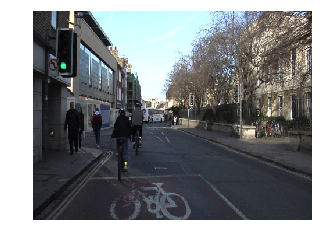

In [52]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [53]:
def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
    'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

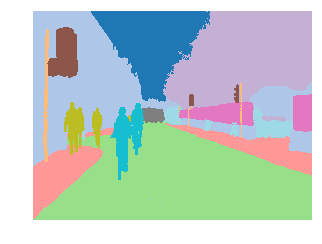

In [54]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [55]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([360, 480]), tensor([[[1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          [1, 1, 1,  ..., 5, 5, 5],
          ...,
          [4, 4, 4,  ..., 3, 3, 3],
          [4, 4, 4,  ..., 3, 3, 3],
          [3, 3, 3,  ..., 3, 3, 3]]]))

## Datasets

In [56]:
bs,size = 8,src_size//2

In [57]:
src = (SegmentationItemList.from_folder(path)
       .split_by_folder(valid='val')
       .label_from_func(get_y_fn, classes=codes))

In [58]:
data = (src.transform(get_transforms(), tfm_y=True)
        .databunch(bs=bs, num_workers=0)
        .normalize(imagenet_stats))

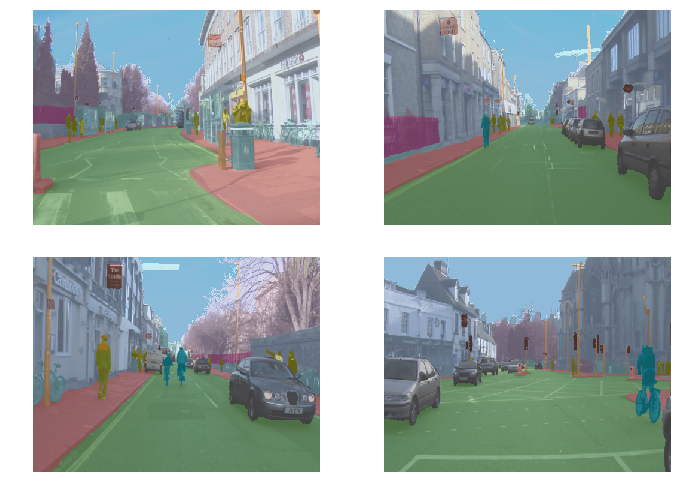

In [59]:
data.show_batch(2, figsize=(10,7))

## Model

In [60]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [61]:
metrics=acc_camvid
wd=1e-2

In [62]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, model_dir='/tmp/models')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


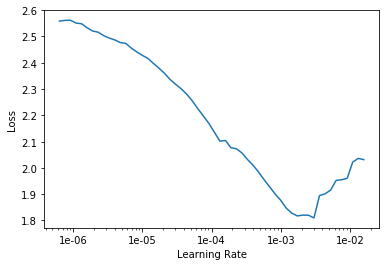

In [63]:
lr_find(learn)
learn.recorder.plot()

In [64]:
lr=2e-3

In [65]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,1.013591,0.800113,0.772259
2,0.736304,0.539074,0.858679
3,0.611528,0.509056,0.845271
4,0.581341,0.529311,0.873863
5,0.502600,0.423248,0.870054
6,0.858131,4.526568,0.401497
7,1.633498,1.304398,0.620408
8,1.262895,1.106866,0.712930
9,0.921896,0.590116,0.800525
10,0.701925,0.564200,0.809598


In [66]:
learn.save('stage-1')

In [67]:
learn.load('stage-1');

In [68]:
learn.unfreeze()

In [69]:
lrs = slice(lr/100,lr)

In [70]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.522139,0.517483,0.856418
2,0.494163,0.467533,0.867509
3,0.450447,0.409761,0.872361
4,0.421157,0.370706,0.886215
5,0.390804,0.379941,0.888898
6,0.377112,0.327812,0.903784
7,0.374137,0.331753,0.894729
8,0.351336,0.552287,0.856056
9,0.342851,0.347291,0.900734
10,0.334116,0.280127,0.922087


In [71]:
learn.save('stage-2');

## Go big

This section runs too long to finish in a single Kernel session. If you want to explore it, try uncommenting the learn.fit_one_cycle lines.

In [72]:
learn=None
gc.collect()

42

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [73]:
size = src_size
bs=3

In [74]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [75]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd, model_dir="/tmp/models").load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


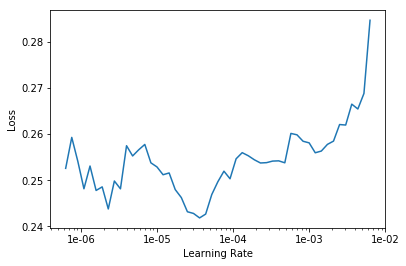

In [76]:
lr_find(learn)
learn.recorder.plot()

In [77]:
lr=1e-3

In [78]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid
1,0.254316,0.244563,0.923957
2,0.247085,0.249198,0.920577
3,0.248908,0.240526,0.930657
4,0.253589,0.261002,0.917288
5,0.242554,0.236828,0.932583
6,0.258039,0.238324,0.933237
7,0.256401,0.271304,0.923375
8,0.257097,0.257234,0.926556
9,0.230755,0.227173,0.933630
10,0.196539,0.234922,0.932202


In [79]:
learn.save('stage-1-big')

In [80]:
learn.load('stage-1-big');

In [81]:
learn.unfreeze()

In [82]:
lrs = slice(lr/1000,lr/10)

In [83]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid
1,0.193549,0.234783,0.932931
2,0.195202,0.224991,0.935764
3,0.190439,0.236062,0.933265
4,0.184846,0.238009,0.933349
5,0.182167,0.240255,0.931592
6,0.178666,0.228928,0.934483
7,0.180117,0.231930,0.933610
8,0.177690,0.224206,0.936493
9,0.179094,0.218653,0.937924
10,0.177105,0.225768,0.936350


In [84]:
learn.save('stage-2-big')

In [85]:
learn.load('stage-2-big');

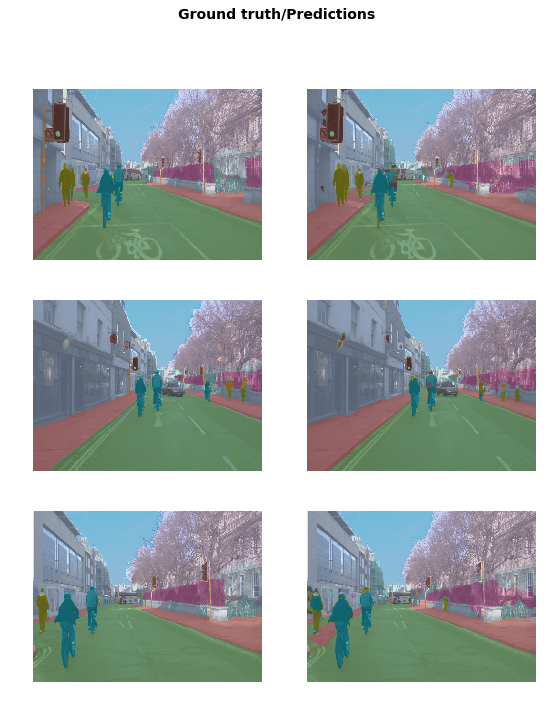

In [86]:
learn.show_results(rows=3, figsize=(9,11))

## fin

In [87]:
# start: 480x360

In [89]:
print(learn.summary())

Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [3, 64, 180, 240]    9408       True      
______________________________________________________________________
BatchNorm2d          [3, 64, 180, 240]    128        True      
______________________________________________________________________
ReLU                 [3, 64, 180, 240]    0          False     
______________________________________________________________________
MaxPool2d            [3, 64, 90, 120]     0          False     
______________________________________________________________________
Conv2d               [3, 64, 90, 120]     36864      True      
______________________________________________________________________
BatchNorm2d          [3, 64, 90, 120]     128        True      
______________________________________________________________________
ReLU                 [3, 64, 90, 120]     0          False     
______________________________________________________________